# MLPRegressor

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter("ignore")

In [1406]:
all_mae = {}
all_r2 = {}

In [2322]:
params = {
    'hidden_layer_sizes': (700, 700),
    'max_iter': 1000,
    'random_state': 1,
    'solver': 'lbfgs',
}

## Почасовой прогноз

#### Один параметр

In [2323]:
energo = pd.read_csv('result.csv', index_col='Местное время в Красноярске')
# energo[['Генерация, МВт*ч\\', 'Потребление, МВт*ч', 'T', 'Po', 'U', 'Ff', 'VV']].head(5)

In [2324]:
target = 'Потребление, МВт*ч'
names = [target]

In [2325]:
energo = energo[names]

In [2326]:
four_old = energo.iloc[: 24 * 7 * 4]
n_four_old = four_old.shape[0]
n_four_old

672

In [2327]:
three_new = energo.iloc[energo.shape[0] - 24 * 7 * 3 -24*7 : -24*7]
n_three_new = three_new.shape[0]
n_three_new

504

In [2328]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.concat((four_old, three_new)))

In [2329]:
analysis_length = 72
preemption_length = 168

In [2330]:
train_x = ([scaler.transform(four_old)[i: i+analysis_length] for i in range(n_four_old - analysis_length)] +
    [scaler.transform(three_new)[i: i+analysis_length] for i in range(n_three_new - analysis_length)])

In [2331]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [2332]:
gr_train_x = list(map(np.concatenate, train_x))

In [2333]:
train_subs = np.concatenate((scaler.transform(four_old)[analysis_length-n_four_old:],
    scaler.transform(three_new)[analysis_length-n_three_new:])).T

In [2334]:
train_y = train_subs[-1]

In [2335]:
g_model = MLPRegressor(**params).fit(gr_train_x, train_y)

In [2336]:
series = scaler.transform(three_new)[-analysis_length:].T.tolist()

In [2337]:
for _ in tqdm.tqdm(range(preemption_length)):
    s = np.array([i[-analysis_length:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 2099.99it/s]


In [2338]:
y_true = [i[-1] for i in scaler.transform(energo.iloc[-preemption_length-analysis_length:])]

In [2339]:
def plot(y_true, series, analysis_length):
    r1 = np.array(range(len(y_true[:analysis_length])))
    r2 = np.array(range(len(y_true[:analysis_length]), len(y_true)))

    plt.figure(figsize=(8,4))
    plt.plot(r1, y_true[:analysis_length], zorder=10,
             color='orange', label='Inputs', marker='v', ms=3)
    plt.plot(r2, series[-1][analysis_length:],
             color='red', label='Predictions', marker='s', ms=3)
    plt.plot(r2, y_true[analysis_length:],
             color='green', label='Labels', marker='.', ms=5)
    _ = plt.legend()

    plt.show()

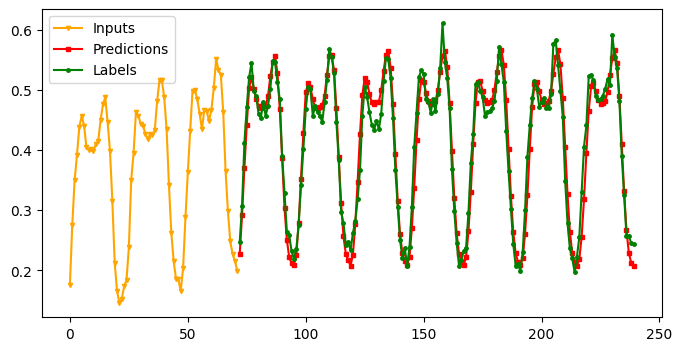

In [2340]:
plot(y_true, series, analysis_length)

In [2341]:
all_mae["hourly univariate"] = mean_absolute_error(y_true[analysis_length:], series[-1][analysis_length:])
all_r2["hourly univariate"] = r2_score(y_true[analysis_length:], series[-1][analysis_length:])
print(
    f"MAE: {all_mae['hourly univariate']:0.6f}\n"
    f"R2: {all_r2['hourly univariate']:0.6f}"
)

MAE: 0.021108
R2: 0.947156


#### Несколько параметров

In [2342]:
energo = pd.read_csv('result.csv')

In [2343]:
labels = [
    'Генерация, МВт*ч\\',
    'T',
    'Po',
    'U', 'Ff', 'VV'
]
target = 'Потребление, МВт*ч'
names = labels + [target]

In [2344]:
energo = energo[names]

In [2345]:
four_old = energo.iloc[: 24 * 7 * 4]
n_four_old = four_old.shape[0]
n_four_old

672

In [2346]:
three_new = energo.iloc[energo.shape[0] - 24 * 7 * 3 -24*7 : -24*7]
n_three_new = three_new.shape[0]
n_three_new

504

In [2347]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.concat((four_old, three_new)))

In [2348]:
train_x = ([scaler.transform(four_old)[i: i+analysis_length] for i in range(n_four_old - analysis_length)] +
    [scaler.transform(three_new)[i: i+analysis_length] for i in range(n_three_new - analysis_length)])

In [2349]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [2350]:
gr_train_x = list(map(np.concatenate, train_x))

In [2351]:
train_subs = np.concatenate((scaler.transform(four_old)[analysis_length-n_four_old:],
    scaler.transform(three_new)[analysis_length-n_three_new:])).T

In [2352]:
train_y = train_subs[-1]

In [2353]:
sub_models = [MLPRegressor(**params) for _ in train_subs[:-1]]
g_model = MLPRegressor(**params)

In [2354]:
_ = g_model.fit(gr_train_x, train_y)

In [2355]:
for i in tqdm.tqdm(range(len(sub_models))):
    sub_models[i].fit(s_train_x[i], train_subs[i])

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:17<00:00, 23.00s/it]


In [2356]:
series = scaler.transform(three_new)[-analysis_length:].T.tolist()

In [2357]:
for _ in tqdm.tqdm(range(preemption_length)):
    for i in range(sh-1):
        series[i].append(sub_models[i].predict([series[i][-analysis_length:]])[0])

100%|███████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 280.94it/s]


In [2358]:
for _ in tqdm.tqdm(range(preemption_length)):
    s = np.array([i[-analysis_length:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|██████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 1263.10it/s]


In [2359]:
y_true = [i[-1] for i in scaler.transform(energo.iloc[-preemption_length-analysis_length:])]

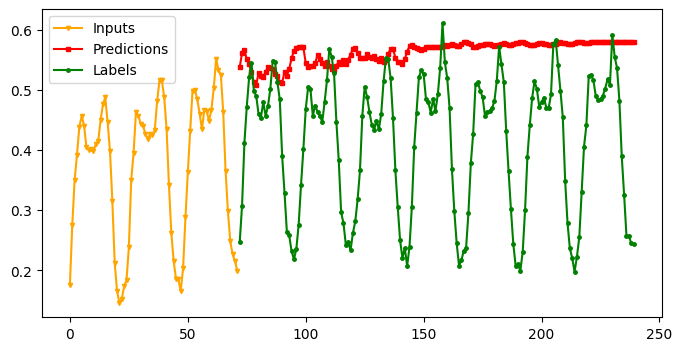

In [2360]:
plot(y_true, series, analysis_length)

In [2361]:
all_mae["hourly multivariate"] = mean_absolute_error(y_true[analysis_length:], series[-1][analysis_length:])
all_r2["hourly multivariate"] = r2_score(y_true[analysis_length:], series[-1][analysis_length:])

## Посуточный прогноз

#### Один параметр

In [2362]:
energo = pd.read_csv('result.csv')

In [2363]:
target = 'Потребление, МВт*ч'
names = [target]

In [2364]:
days = len(energo[target])
hours = days // 24

In [2365]:
d = {i: [j.mean() for j in np.array(energo[i])[:24*hours].reshape((hours, 24))] for i in names}

In [2366]:
energo_d = pd.DataFrame(d)

In [2367]:
n_old = 260
old = energo_d.iloc[: n_old]

In [2368]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(old)

In [2369]:
analysis_length = 30
preemption_length = 30

In [2370]:
train_x = ([scaler.transform(old)[i: i+analysis_length] for i in range(n_old - analysis_length)])

In [2371]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [2372]:
gr_train_x = list(map(np.concatenate, train_x))

In [2373]:
train_subs = scaler.transform(old)[analysis_length-n_old:].T

In [2374]:
train_y = train_subs[-1]

In [2375]:
g_model = MLPRegressor(**params).fit(gr_train_x, train_y)

In [2376]:
series = scaler.transform(old)[-analysis_length:].T.tolist()

In [2377]:
for _ in tqdm.tqdm(range(preemption_length)):
    s = np.array([i[-analysis_length:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1764.59it/s]


In [2378]:
y_true = [i[-1] for i in scaler.transform(energo_d.iloc[-preemption_length-analysis_length:])]

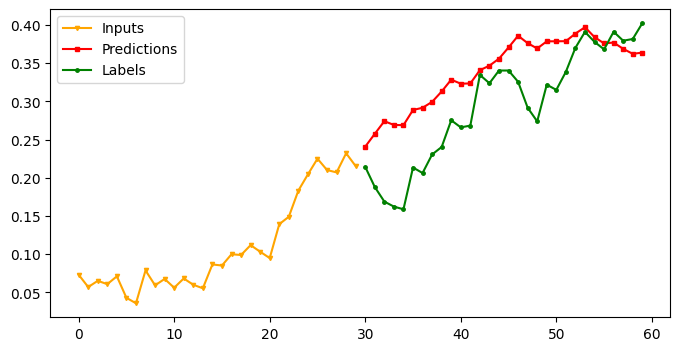

In [2379]:
plot(y_true, series, analysis_length)

In [2380]:
all_mae["daily univariate"] = mean_absolute_error(y_true[analysis_length:], series[-1][analysis_length:])
all_r2["daily univariate"] = r2_score(y_true[analysis_length:], series[-1][analysis_length:])

#### Несколько параметров

In [2381]:
labels = [
    'Генерация, МВт*ч\\',
    'T',
    # 'Po',
    # 'U', 'Ff', 'VV'
]
target = 'Потребление, МВт*ч'
names = labels + [target]

In [2382]:
days = len(energo[target])
hours = days // 24

In [2383]:
d = {i: [j.mean() for j in np.array(energo[i])[:24*hours].reshape((hours, 24))] for i in names}

In [2384]:
energo_d = pd.DataFrame(d)

In [2385]:
n_old = 260
old = energo_d.iloc[: n_old]

In [2386]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(old)

In [2387]:
train_x = ([scaler.transform(old)[i: i+analysis_length] for i in range(n_old - analysis_length)])

In [2388]:
sh = np.array(train_x).shape[2]
s_train_x = [[] for _ in range(sh)]

for i in train_x:
    for j in range(sh):
        s_train_x[j].append(i.T[j])

In [2389]:
gr_train_x = list(map(np.concatenate, train_x))

In [2390]:
train_subs = scaler.transform(old)[analysis_length-n_old:].T

In [2391]:
train_y = train_subs[-1]

In [2392]:
sub_models = [MLPRegressor(**params) for _ in train_subs[:-1]]
g_model = MLPRegressor(**params)

In [2393]:
_ = g_model.fit(gr_train_x, train_y)

In [2394]:
for i in tqdm.tqdm(range(len(sub_models))):
    sub_models[i].fit(s_train_x[i], train_subs[i])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:52<00:00, 26.20s/it]


In [2395]:
series = scaler.transform(old)[-analysis_length:].T.tolist()

In [2396]:
for _ in tqdm.tqdm(range(preemption_length)):
    for i in range(sh-1):
        series[i].append(sub_models[i].predict([series[i][-analysis_length:]])[0])

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 789.49it/s]


In [2397]:
for _ in tqdm.tqdm(range(preemption_length)):
    s = np.array([i[-analysis_length:] for i in series]).reshape(-1)
    series[-1].append(g_model.predict([s])[0])

100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1578.67it/s]


In [2398]:
y_true = [i[-1] for i in scaler.transform(energo_d.iloc[-preemption_length-analysis_length:])]

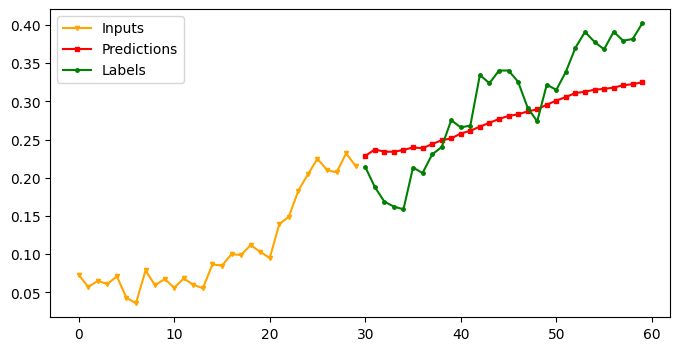

In [2399]:
plot(y_true, series, analysis_length)

In [2400]:
all_mae["daily multivariate"] = mean_absolute_error(y_true[analysis_length:], series[-1][analysis_length:])
all_r2["daily multivariate"] = r2_score(y_true[analysis_length:], series[-1][analysis_length:])

## Сравнение

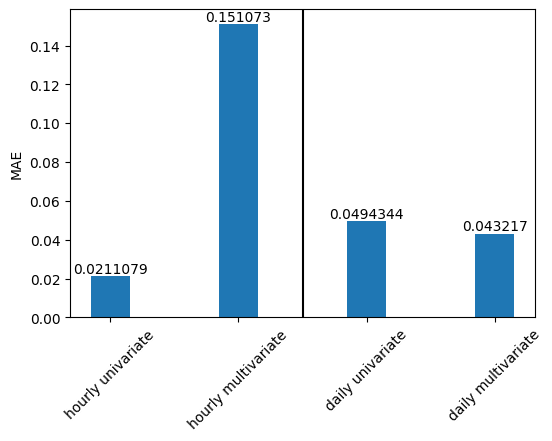

In [2401]:
x = np.arange(len(all_mae))
width = 0.3
y = all_mae.values()

plt.figure(figsize=(6, 4))
bar1 = plt.bar(x, y, width)
plt.bar_label(bar1)
plt.xticks(ticks=x, labels=all_mae.keys(), rotation=45)
plt.ylabel(f'MAE')
plt.axvline(x=1.5, color='black')
plt.show()

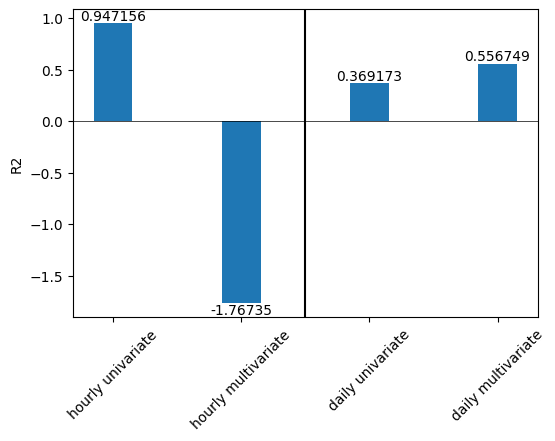

In [2402]:
x = np.arange(len(all_r2))
width = 0.3
y = all_r2.values()

plt.figure(figsize=(6, 4))
bar1 = plt.bar(x, y, width)
plt.bar_label(bar1)
plt.xticks(ticks=x, labels=all_mae.keys(), rotation=45)
plt.ylabel(f'R2')
plt.axvline(x=1.5, color='black')
plt.axhline(y=0, color='black', linewidth=.5)
plt.show()